# Import modules and set up workspace

In [8]:
import arcpy
import psycopg2
from arcgis.gis import GIS
from arcgis.features import FeatureLayerCollection
from psycopg2 import sql
from psycopg2.extras import RealDictCursor

In [2]:
arcpy.env.workspace = r"C:\Users\cason\Documents\GIS5572\Lab1"
workspace = arcpy.env.workspace

# Build polygon geometry starting with point coordinates

In [3]:
p1 = arcpy.Point(5,2)
p2 = arcpy.Point(10,14)
p3 = arcpy.Point(15,6)

In [4]:
point_list = [p1, p2, p3]
point_list

[<Point (5.0, 2.0, #, #)>, <Point (10.0, 14.0, #, #)>, <Point (15.0, 6.0, #, #)>]

In [5]:
array = arcpy.Array(point_list)
array

<Array [<Point (5.0, 2.0, #, #)>, <Point (10.0, 14.0, #, #)>, <Point (15.0, 6.0, #, #)>]>

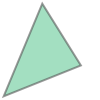

In [6]:
polygon = arcpy.Polygon(array)
polygon

In [7]:
spatial_reference = arcpy.SpatialReference(4326)

In [8]:
polygon.SR = spatial_reference

In [9]:
polygon_wkt = polygon.WKT
polygon_wkt

'MULTIPOLYGON (((5.0001220703125 2.0001220703125, 15.0001220703125 6.0001220703125, 10.0001220703125 14.0001220703125, 5.0001220703125 2.0001220703125)))'

# Connect to PostgreSQL database and write polygon to table as WKT

In [10]:
conn = psycopg2.connect(host = "34.135.163.144",
                       database = "lab1",
                       user = "postgres",
                       password = "----",
                       port = "5432")

In [11]:
cursor = conn.cursor()

In [12]:
cursor.execute("CREATE TABLE IF NOT EXISTS poly (id SERIAL PRIMARY KEY, geom GEOMETRY)")
cursor.execute("INSERT INTO poly (geom) VALUES (ST_GeomFromText('{}', 4326))".format(polygon_wkt))
conn.commit()
conn.close()

# Import polygon from Google Cloud VM and save locally as JSON file

In [18]:
import requests

url = "http://34.125.225.68:5000/get_polygon"
response = requests.get(url)

if response.status_code == 200:
    geojson = response.json()
    with open("C:/Users/cason/Desktop/GIS5572/GIS5572/Lab1/my_geojson.geojson", "w") as f:
        f.write(str(geojson))
        print("File saved successfully")
        
else:
    print("Failed to execute")

File saved successfully


In [5]:
import json

json_string = '{"geometry": {"coordinates": [[[[5.00012207, 2.00012207], [15.00012207, 6.00012207], [10.00012207, 14.00012207], [5.00012207, 2.00012207]]]], "type": "MultiPolygon"}, "poly": "(1,0106000020E61000000100000001030000000100000004000000000000002000144000000000400000400000000010002E40000000002000184000000000100024400000000010002C4000000000200014400000000040000040)"}'

json_obj = json.loads(json_string)

new_json_obj = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": json_obj['geometry'],
            "properties": {
                "poly": json_obj['poly']
            }
            
        }
    ]
}

new_json_string = json.dumps(new_json_obj)

print(new_json_string)

{"type": "FeatureCollection", "features": [{"type": "Feature", "geometry": {"coordinates": [[[[5.00012207, 2.00012207], [15.00012207, 6.00012207], [10.00012207, 14.00012207], [5.00012207, 2.00012207]]]], "type": "MultiPolygon"}, "properties": {"poly": "(1,0106000020E61000000100000001030000000100000004000000000000002000144000000000400000400000000010002E40000000002000184000000000100024400000000010002C4000000000200014400000000040000040)"}}]}


In [6]:
with open("C:/Users/cason/Desktop/GIS5572/GIS5572/Lab1/json_esri.json", "w") as json_file:
    json.dump(new_json_obj, json_file)

# Export GeoJSON file to AGOL

In [33]:
gis = GIS("https://www.arcgis.com", "casones1597", "----")

item = gis.content.add({'type': 'GeoJson'}, "C:/Users/cason/Desktop/GIS5572/GIS5572/Lab1/json_esri.json")

feature_layer = item.publish()

feature_layer_url = feature_layer.url
print(feature_layer_url)


Exception: Item 'json_esri.json' already exists.
(Error Code: 409)